<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/QMetrics%20Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
print(tf.__version__)

2.3.0


In [2]:
from IPython.display import clear_output

! git clone https://github.com/nahumsa/DM-Reconstruction
% cd DM-Reconstruction/
! pip install qutip
clear_output()

# Qutip error

In [15]:
import qutip as qutip
import numpy as np

In [16]:
def unitary(theta, phi, lbda):
  return np.array([[np.cos(theta/2),-np.exp(1j*lbda)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(phi+lbda)*np.cos(theta/2))]])

def add_error(dm, theta, phi, lbda, qubit=1):
  err = qutip.Qobj(unitary(theta,phi,lbda))
  if qubit == 1:
    err = qutip.tensor(qutip.identity(2),err)  
  elif qubit == 2:
    err = qutip.tensor(err,qutip.identity(2))  
  return dm*err

In [17]:
from itertools import product

def measurement(density_matrix, base, name_base):
  """Measuring the quantum state on a given basis.
  """
  _measurements_names = []
  _measurements = []

  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_base, base),zip(name_base, base)):
    #Ignore the II measurement because it is always 1
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      measurement_op = qutip.tensor(meas_1,meas_2)
      _measurements.append(qutip.expect(measurement_op, density_matrix))
      _measurements_names.append(name_1 + name_2)

  return [i for i in zip(_measurements, _measurements_names)]

def create_dataset_err(n_samples, theta=0., phi=0., lbda=0., qubit=1):
  """Create dataset.
  
  Parameters:
  n_samples(int): Number of samples.
  theta(float): Parameter for the error.
  phi(float): Parameter for the error.
  lbda(float): Parameter for the error.
  qubit(int): In which qubit you want to put the error.
  
  Output:
  _measurements(list): Measurements.
  _measurements_err(list): Measurements with error.
  """
  
  _measurements = []
  _measurements_err = []

  #Basis Measured
  name_basis = ['I', 'X', 'Y', 'Z']
  basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]



  for _ in range(n_samples):    
    density = qutip.rand_dm(4, density=0.75, dims=[[2,2],[2,2]])
    density_err = add_error(density, theta, phi, lbda, qubit)    
    
    
    val_measurements = measurement(density_matrix=density, 
                                   base=basis, 
                                   name_base=name_basis)
    
    val_measurements_err = measurement(density_matrix=density_err,
                                       base=basis,
                                       name_base=name_basis)
    
    _measurements.append(val_measurements)
    _measurements_err.append(val_measurements_err)
    
  return _measurements, _measurements_err

In [19]:
measurements, measurements_err = create_dataset_err(1)
measurements, measurements_err

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.23080246+0.j          0.0824765 +0.04065453j  0.06117131-0.00761314j
  -0.00839774-0.11608995j]
 [ 0.0824765 -0.04065453j  0.24552505+0.j          0.09369987+0.11302472j
  -0.06518404+0.02824083j]
 [ 0.06117131+0.00761314j  0.09369987-0.11302472j  0.15839995+0.j
   0.10414703+0.06701624j]
 [-0.00839774+0.11608995j -0.06518404-0.02824083j  0.10414703-0.06701624j
   0.36527254+0.j        ]]


([[(0.37324706153513765, 'IX'),
   (-0.2153415547766926, 'IY'),
   (-0.22159518690047564, 'IZ'),
   (-0.00802546358715997, 'XI'),
   (0.17060426919798713, 'XX'),
   (0.458229341067846, 'XY'),
   (0.25271069838525084, 'XZ'),
   (-0.04125539123612237, 'YI'),
   (0.006130476500984999, 'YX'),
   (0.20419522497438827, 'YY'),
   (0.07170793126103758, 'YZ'),
   (-0.04734497744874222, 'ZI'),
   (-0.04334104380133949, 'ZX'),
   (0.052723416900611275, 'ZY'),
   (0.19214999557868156, 'ZZ')]],
 [[(0.37324706153513765, 'IX'),
   (-0.2153415547766926, 'IY'),
   (-0.22159518690047564, 'IZ'),
   (-0.00802546358715997, 'XI'),
   (0.17060426919798713, 'XX'),
   (0.458229341067846, 'XY'),
   (0.25271069838525084, 'XZ'),
   (-0.04125539123612237, 'YI'),
   (0.006130476500984999, 'YX'),
   (0.20419522497438827, 'YY'),
   (0.07170793126103758, 'YZ'),
   (-0.04734497744874222, 'ZI'),
   (-0.04334104380133949, 'ZX'),
   (0.052723416900611275, 'ZY'),
   (0.19214999557868156, 'ZZ')]])

In [20]:
def create_x(measurement):
  """Create an list with all measurements
  Parameters:
  measurement(list): List of measurements and the basis measured.  
  """
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:      
      aux.append(result)
    X.append(aux)
  return X

In [27]:
%load_ext autoreload
%autoreload 2

In [37]:
from Utils.Dataset import create_dataset_err
from Utils.Dataset import create_x


samples_train = 5000
measurements_train, measurements_errors_train = create_dataset_err(samples_train,
                                                                   theta=np.pi/6)

samples_test = 3000
measurements_test, measurements_errors_test = create_dataset_err(samples_test, theta=np.pi/6)

#Transforming in an np.array
X_train = np.array(create_x(measurements_errors_train))
Y_train = np.array(create_x(measurements_train))

X_test = np.array(create_x(measurements_errors_test))
Y_test = np.array(create_x(measurements_test))

np.savetxt('X_train.txt', X_train)
np.savetxt('Y_train.txt', Y_train)
np.savetxt('X_test.txt', X_test)
np.savetxt('Y_test.txt', Y_test)

In [39]:
X_train[0], X_test[0]

(array([ 0.02648361,  0.0491725 ,  0.25014348,  0.03943531, -0.15763333,
        -0.02841025,  0.10245561, -0.19309999, -0.24724841,  0.04281847,
        -0.0330715 , -0.30169592,  0.17940975, -0.18715949,  0.22102461]),
 array([ 0.07583624,  0.11892929, -0.10239556, -0.25844539,  0.35575293,
        -0.40879842, -0.00428185, -0.46485203, -0.09913055, -0.199626  ,
        -0.14106012,  0.30757838,  0.18695782, -0.19610613,  0.01787378]))

# Tests

In [ ]:
#Creating pauli matrices
sigma_0_np = np.array([[1.,0.],
                      [0.,1.]], dtype=np.complex64)

sigma_1_np = np.array([[0.,1.],
                       [1.,0.]], dtype=np.complex64)

sigma_2_np = np.array([[0.,1.j],
                       [-1.j,0.]], dtype=np.complex64)

sigma_3_np = np.array([[1.,0.],
                       [0.,-1.]], dtype=np.complex64)

#Converting to tensors
sigma_0 = tf.Variable(sigma_0_np, tf.complex64)

sigma_1 = tf.Variable(sigma_1_np, tf.complex64)

sigma_2 = tf.Variable(sigma_2_np, tf.complex64)

sigma_3 = tf.Variable(sigma_3_np, dtype=tf.complex64)

In [ ]:
def tf_kron(a: tf.Tensor,
            b: tf.Tensor) -> tf.Tensor:

    """Calculates the Kronocker product of two matrices ((2,2) Tensors).

    Parameters
    -----------------------------------------------------------------------
    a(tf.Tensor): Tensor on the left of the product.
    b(tf.Tensor): Tensor on the right of the product.

    Return
    -----------------------------------------------------------------------
    (tf.tensor): Kronocker product between a and b.

    """
    assert len(a.shape) == 2
    assert len(b.shape) == 2
    a_shape = list(b.shape)    
    b_shape = list(b.shape)
    return tf.reshape(tf.reshape(a,[a_shape[0],1,a_shape[1],1])*tf.reshape(b,[1,b_shape[0],1,b_shape[1]]),[a_shape[0]*b_shape[0],a_shape[1]*b_shape[1]])

In [ ]:
from itertools import product
name_basis_1 = ['I', 'X', 'Y', 'Z']
basis_1 = [sigma_0, sigma_1,sigma_2,sigma_3]
name_basis_2 = []
basis_2 = []
for (name_1, meas_1),(name_2,meas_2) in product(zip(name_basis_1, basis_1),zip(name_basis_1, basis_1)):
  if name_1 == 'I' and name_2 == 'I':
    pass
  else:
    basis_2.append(tf_kron(meas_1,meas_2))
    name_basis_2.append(name_1 + name_2)

basis_2_tf = tf.Variable(basis_2)
print(name_basis_2)
print(basis_2_tf.shape)

['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
(15, 4, 4)


In [ ]:
meas = [np.random.rand(15),np.random.rand(15),np.random.rand(15),np.random.rand(15)]
measurement = np.array(meas, dtype=np.complex64)
measurement_tensor = tf.Variable(measurement, tf.complex64)
#print(measurement_tensor)

In [ ]:
ones_II = tf.ones((measurement_tensor.shape[0],1), dtype=tf.dtypes.complex64)
II = tf.Variable([tf_kron(sigma_0 , sigma_0)])
density_matrix = 0.25*(tf.tensordot(ones_II , II ,axes=1) + tf.tensordot(measurement_tensor,basis_2_tf,axes=1))
print(density_matrix.shape)

(4, 4, 4)


In [ ]:
D = density_matrix[0].numpy()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [ ]:
num = int(np.log2(len(D)))
column_names = ['|'+ bin(i)[2:].zfill(num) +'$\\rangle$' for i in range(2**num)]
row_names = ['$\\langle$' + bin(i)[2:].zfill(num) + '|' for i in range(2**num)]
lx = len(D[0])            # Work out matrix dimensions
ly = len(D[:, 0])

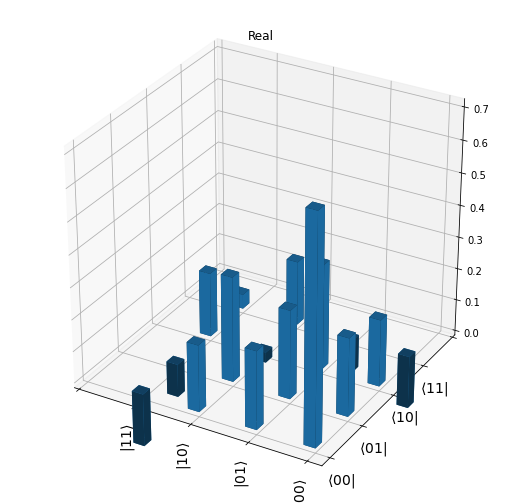

In [ ]:
_x = np.arange(len(D))
_y = np.arange(len(D))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
top = np.imag(D).ravel()
bottom = np.zeros_like(top)
width = depth = 0.2

fig = plt.figure(figsize=(20, 9))

ax1 = fig.add_subplot(121, projection='3d')

ax1.xaxis.set_major_locator(plt.NullLocator())  
ax1.yaxis.set_major_locator(plt.NullLocator())

ax1.bar3d(x, y, bottom, width, depth, np.real(D).flatten(), shade=True)

ax1.set_xticks(np.arange(0, lx+0.5, 1))
ax1.set_yticks(np.arange(0, ly+0.5, 1))
ax1.set_yticklabels(row_names, fontsize=14)
ax1.set_xticklabels(column_names, fontsize=14, rotation=90)
ax1.invert_yaxis()

ax1.set_title('Real')
plt.show()

[ 0.          0.36593223  0.3919465   0.13620794 -0.36593223  0.
 -0.10480136 -0.02736269 -0.3919465   0.10480136  0.         -0.13325788
 -0.13620794  0.02736269  0.13325788  0.        ]


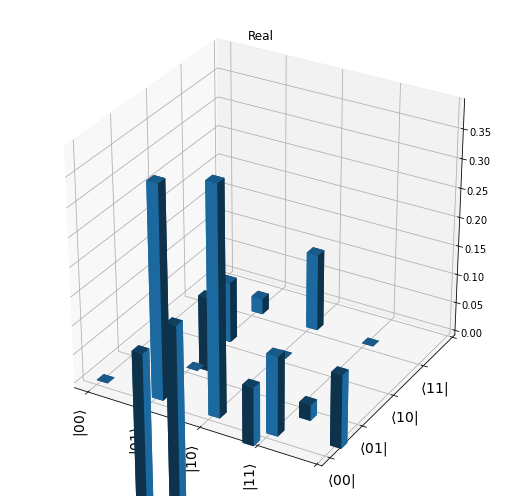

In [ ]:
_x = np.arange(len(D))
_y = np.arange(len(D))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
top = np.imag(D).ravel()
bottom = np.zeros_like(top)
width = depth = 0.2

fig = plt.figure(figsize=(20, 9))

ax1 = fig.add_subplot(121, projection='3d')

ax1.xaxis.set_major_locator(plt.NullLocator())  
ax1.yaxis.set_major_locator(plt.NullLocator())

print(np.imag(D).flatten())
ax1.bar3d(x, y, bottom, width, depth, np.imag(D).flatten(), shade=True)

ax1.set_xticks(np.arange(0, lx+0.5, 1))
ax1.set_yticks(np.arange(0, ly+0.5, 1))
ax1.set_yticklabels(row_names, fontsize=14)
ax1.set_xticklabels(column_names, fontsize=14, rotation=90)

ax1.set_title('Real')
plt.show()

In [ ]:
mat = tf.squeeze(density_matrix)
#print(mat)
print(f'Eigenvalues: {tf.linalg.eigvalsh(mat)}')
log_mat = tf.linalg.logm(mat)

Eigenvalues: [[-0.43625665+0.j -0.12367202+0.j  0.32435423+0.j  1.2355748 +0.j]
 [-0.32802463+0.j  0.01609422+0.j  0.22311276+0.j  1.0888174 +0.j]
 [-0.3953889 +0.j -0.20475198+0.j  0.29422307+0.j  1.3059181 +0.j]
 [-0.2513447 +0.j -0.05367637+0.j  0.3436877 +0.j  0.96133393+0.j]]


In [ ]:
def pretty_good_fidelity(A,B):
  """ Function for the pretty good fidelity, given by:
  Tr(\sqrt{A}\sqrt{B})
  
  """
  return tf.math.real(tf.linalg.trace(tf.linalg.sqrtm(A)@tf.linalg.sqrtm(B)))

In [ ]:
tf.linalg.trace(tf.linalg.sqrtm(mat)@tf.linalg.sqrtm(mat))

<tf.Tensor: shape=(4,), dtype=complex64, numpy=
array([0.99999964+4.4470653e-08j, 1.0000004 -1.4901161e-08j,
       0.9999999 -4.2840838e-08j, 1.0000005 +4.4237822e-08j],
      dtype=complex64)>

In [ ]:
tf.sqrt(pretty_good_fidelity(mat,mat))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9999998 , 1.0000001 , 0.99999994, 1.0000002 ], dtype=float32)>

# Methods

## One qubit

In [ ]:
def create_density_mat(measurements: np.array) -> tf.Tensor:
  
  #Creating the basis
  sigma_0_np = np.array([[1.,0.],
                        [0.,1.]], dtype=np.complex64)

  sigma_1_np = np.array([[0.,1.],
                         [1.,0.]], dtype=np.complex64)

  sigma_2_np = np.array([[0.,1.j],
                         [-1.j,0.]], dtype=np.complex64)

  sigma_3_np = np.array([[1.,0.],
                        [0.,-1.]], dtype=np.complex64)

  #Converting to tensors
  sigma_0 = tf.Variable(sigma_0_np, tf.complex64)

  sigma_1 = tf.Variable(sigma_1_np, tf.complex64)

  sigma_2 = tf.Variable(sigma_2_np, tf.complex64)

  sigma_3 = tf.Variable(sigma_3_np, dtype=tf.complex64)

  basis = tf.Variable([sigma_1,sigma_2,sigma_3])
  
  measurement = np.array(measurements, dtype=np.complex64)
  measurement_tensor = tf.Variable(measurement, tf.complex64)

  density_matrix = 0.5*(sigma_0 + tf.tensordot(measurement_tensor,basis,axes=1))
  return density_matrix

In [ ]:
def trace_dist(A,B):
  dif = A - B
  dif = tf.transpose(dif, conjugate=True, perm=[0,2,1]) * dif  
  vals = tf.linalg.eigvalsh(dif)
  return tf.math.real(0.5*tf.reduce_sum(tf.math.sqrt(tf.math.abs(vals)),axis=-1))

In [ ]:
def trace_loss(y_true,y_pred):
  d_y_true = create_density_mat(y_true)  
  d_y_pred = create_density_mat(y_pred)  
  return tf.reduce_mean(trace_dist(d_y_pred,d_y_true))

In [ ]:
def entropy(A):    
  eigen_A = tf.linalg.eigvalsh(A)
  return -tf.math.real(tf.reduce_sum(eigen_A*tf.math.log(eigen_A),axis=-1))

def relative_entropy(A,B):
  log_B = tf.linalg.logm(B)
  eigen_AlogB = tf.linalg.eigvalsh(A*log_B)
  return - entropy(A) - tf.math.real(tf.reduce_sum(eigen_AlogB,axis=-1)) 

In [ ]:
def r_entropy_loss(y_true,y_pred):
  d_y_true = create_density_mat(y_true)  
  d_y_pred = create_density_mat(y_pred)  
  return tf.reduce_mean(relative_entropy(d_y_pred,d_y_true))

In [ ]:
y_1 = [[.5,.5,0],[.2,0.3,.3]]
y_2 = [[1,0,0],[.2,.3,.3]]
r_entropy_loss(y_true=y_1, y_pred=y_2)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.12907417>

## Two qubits

In [ ]:
from itertools import product
def tf_kron(a: tf.Tensor,
            b: tf.Tensor) -> tf.Tensor:

  """Calculates the Kronocker product of two matrices ((2,2) Tensors).

  Parameters
  -----------------------------------------------------------------------
  a(tf.Tensor): Tensor on the left of the product.
  b(tf.Tensor): Tensor on the right of the product.

  Return
  -----------------------------------------------------------------------
  (tf.tensor): Kronocker product between a and b.

  """
  assert len(a.shape) == 2
  assert len(b.shape) == 2
  a_shape = list(b.shape)    
  b_shape = list(b.shape)
  return tf.reshape(tf.reshape(a,[a_shape[0],1,a_shape[1],1])*tf.reshape(b,[1,b_shape[0],1,b_shape[1]]),[a_shape[0]*b_shape[0],a_shape[1]*b_shape[1]])


#Creating pauli matrices
sigma_0_np = np.array([[1.,0.],
                      [0.,1.]], dtype=np.complex64)

sigma_1_np = np.array([[0.,1.],
                       [1.,0.]], dtype=np.complex64)

sigma_2_np = np.array([[0.,1.j],
                       [-1.j,0.]], dtype=np.complex64)

sigma_3_np = np.array([[1.,0.],
                       [0.,-1.]], dtype=np.complex64)

#Converting to tensors
sigma_0 = tf.Variable(sigma_0_np, tf.complex64)

sigma_1 = tf.Variable(sigma_1_np, tf.complex64)

sigma_2 = tf.Variable(sigma_2_np, tf.complex64)

sigma_3 = tf.Variable(sigma_3_np, dtype=tf.complex64)

def create_2qubit_density_mat(measurements: tf.Variable) -> tf.Variable:
  
  name_basis_1 = ['I', 'X', 'Y', 'Z']
  basis_1 = [sigma_0, sigma_1,sigma_2,sigma_3]
  name_basis_2 = []
  basis_2 = []
  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_basis_1, basis_1),zip(name_basis_1, basis_1)):
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      basis_2.append(tf_kron(meas_1,meas_2))
      name_basis_2.append(name_1 + name_2)
  
  basis_2_tf = tf.Variable(basis_2)

  # Helper to make tr(density_matrix) = 1
  ones_II = tf.ones((tf.shape(measurements)[0],1), dtype=tf.dtypes.complex64)
  II = tf.Variable([tf_kron(sigma_0 , sigma_0)])
  
  density_matrix = 0.25*(tf.tensordot(ones_II , II ,axes=1) + tf.tensordot(measurements,basis_2_tf,axes=1))
  return density_matrix

In [ ]:
def trace_dist(A,B):
  dif = tf.math.subtract(A,B)
  
  dif = tf.transpose(dif, conjugate=True, perm=[0,2,1]) * dif  
  vals = tf.linalg.eigvalsh(dif)
  return tf.math.real(0.5*tf.reduce_sum(tf.math.sqrt(tf.math.abs(vals)),axis=-1))

def trace_loss(y_true,y_pred):
  d_y_true = create_2qubit_density_mat(y_true)  
  d_y_pred = create_2qubit_density_mat(y_pred)    
  return tf.reduce_mean(trace_dist(d_y_pred,d_y_true))

In [ ]:
def entropy(A):    
  eigen_A = tf.linalg.eigvalsh(A)
  return -tf.math.real(tf.reduce_sum(eigen_A*tf.math.log(eigen_A),axis=-1))

def relative_entropy(A,B):
  log_B = tf.linalg.logm(B)
  eigen_AlogB = tf.linalg.eigvalsh(tf.tensordot(A,log_B, axes=1))
  return - entropy(A) - tf.math.real(tf.reduce_sum(eigen_AlogB,axis=-1)) 

def r_entropy_loss(y_true,y_pred):
  d_y_true = create_2qubit_density_mat(y_true)  
  d_y_pred = create_2qubit_density_mat(y_pred)  
  return tf.reduce_mean(relative_entropy(d_y_pred,d_y_true))

In [ ]:
meas_1 = [np.random.rand(15),np.random.rand(15),np.random.rand(15)]
measurement_1 = np.array(meas_1, dtype=np.complex64)
measurement_tensor_1 = tf.Variable(measurement_1, tf.complex64)

meas_2 = [np.random.rand(15),np.random.rand(15),np.random.rand(15)]
measurement_2 = np.array(meas_2, dtype=np.complex64)
measurement_tensor_2 = tf.Variable(measurement_2, tf.complex64)

print(entropy(create_2qubit_density_mat(measurement_tensor_1)))
print(trace_loss(measurement_tensor_1,measurement_tensor_2))
#print(r_entropy_loss(measurement_tensor_1,measurement_tensor_2))

tf.Tensor([-0.32317808 -0.5595948  -0.2129062 ], shape=(3,), dtype=float32)
tf.Tensor(0.586917, shape=(), dtype=float32)


## Fidelity

In [ ]:
meas_1 = [np.random.rand(15),np.random.rand(15),np.random.rand(15)]
measurement_1 = np.array(meas_1, dtype=np.complex64)
measurement_tensor_1 = tf.Variable(measurement_1, tf.complex64)

meas_2 = [np.random.rand(15),np.random.rand(15),np.random.rand(15)]
measurement_2 = np.array(meas_2, dtype=np.complex64)
measurement_tensor_2 = tf.Variable(measurement_2, tf.complex64)

In [ ]:
def pretty_good_fidelity(A,B):
  """ Function for the pretty good fidelity, given by:
  Tr(\sqrt{A}\sqrt{B})
  
  """
  return tf.math.real(tf.linalg.trace(tf.linalg.sqrtm(A)@tf.linalg.sqrtm(B)))

In [ ]:
print(pretty_good_fidelity(create_2qubit_density_mat(measurement_tensor_1),create_2qubit_density_mat(measurement_tensor_1)))
print(tf.sqrt(pretty_good_fidelity(create_2qubit_density_mat(measurement_tensor_1),create_2qubit_density_mat(measurement_tensor_1))))

tf.Tensor([1.0000001 1.0000012 1.0000021], shape=(3,), dtype=float32)
tf.Tensor([1.        1.0000006 1.0000011], shape=(3,), dtype=float32)


In [ ]:
def fidelity(A,B):
  """ Calculates the fidelity between density matrices A and B.
  """
  sqrt_A = tf.linalg.sqrtm(A)  
  aux = sqrt_A@B@sqrt_A
  internal = tf.linalg.sqrtm(aux)
  eigenvalues = tf.linalg.eigvalsh(internal)  
  return tf.math.real(tf.reduce_sum(tf.sqrt(eigenvalues), axis=-1))

In [ ]:
fidelity(create_2qubit_density_mat(measurement_tensor_1),create_2qubit_density_mat(measurement_tensor_1))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.1140258, 1.7614529, 1.8742006], dtype=float32)>

In [ ]:
def dagger(A):
  """Computes the transpose conjulgate of a density matrix A.
  
  """
  return tf.transpose(A, perm=[0,2,1], conjugate=True)    

def fidelity(A,B):    
  """ Calculates the fidelity between density matrices A and B.
  """
  (eigenvalues_A, vector_A) = tf.linalg.eig(A)   
  aux_fidelity = vector_A@tf.linalg.diag(tf.math.sqrt(eigenvalues_A))@dagger(vector_A)    
  f_b = aux_fidelity@B@dagger(aux_fidelity)
  (eigenvalues_F, vector_F) = tf.linalg.eig(f_b)    
  return tf.square(tf.math.real(tf.linalg.trace(vector_F@tf.linalg.diag(tf.math.sqrt(eigenvalues_F))@dagger(vector_F))))

In [ ]:
fidelity(create_2qubit_density_mat(measurement_tensor_1),create_2qubit_density_mat(measurement_tensor_1))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.4242904, 1.9064056, 2.0652583], dtype=float32)>

In [ ]:
def sqrt_svd(A):
  S, left_A, right_A = tf.linalg.svd(density)
  S = tf.cast(tf.linalg.diag(tf.sqrt(S)),dtype='complex64')
  return left_A@S@dagger(right_A)

def fidelity(A,B):
  sqrt_A = sqrt_svd(A)
  internal = sqrt_A@B@sqrt_A
  sqrt_internal = sqrt_svd(internal)
  return tf.square(tf.math.real(tf.linalg.trace(sqrt_internal)))

In [ ]:
fidelity(create_2qubit_density_mat(measurement_tensor_1),create_2qubit_density_mat(measurement_tensor_1))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.37355238, 1.0448463 , 1.385976  ], dtype=float32)>